In [2]:
import sys,os,os.path
sys.path.append("../../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [3]:
print(np.__version__)

1.20.3


In [3]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)



### lets try and load the sophronia stuff here

In [4]:
# loading sophronia file
soph_file = f'../HPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5'
#soph_file = f'../LPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,23.325,0.0,0.0,228.951996,5.159420,1923.000000,-1.0,0.004984,-1,-1.0
1,2080000,2.080001e+12,0,79.178449,12.635942,1,69.975,7.775,0.0,0.0,229.781265,15.884058,870.508545,-1.0,0.002266,-1,-1.0
2,2080000,2.080001e+12,0,79.178449,12.635942,1,69.975,23.325,0.0,0.0,229.781265,14.434783,791.082581,-1.0,0.002046,-1,-1.0
3,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,7.775,0.0,0.0,229.781265,15.188406,832.384094,-1.0,0.002172,-1,-1.0
4,2080000,2.080001e+12,0,79.178449,12.635942,1,85.525,23.325,0.0,0.0,229.781265,8.521739,467.024658,-1.0,0.001211,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
902461,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-241.025,7.775,0.0,0.0,383.400238,8.985507,400.845184,-1.0,0.001095,-1,-1.0
902462,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-225.475,7.775,0.0,0.0,383.400238,7.014493,312.917847,-1.0,0.000846,-1,-1.0
902463,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-225.475,23.325,0.0,0.0,383.400238,13.797101,615.491272,-1.0,0.001655,-1,-1.0
902464,2083610,2.083612e+12,0,-226.889978,-7.595709,1,-209.925,23.325,0.0,0.0,383.400238,6.898551,307.745636,-1.0,0.000827,-1,-1.0


### And convert to the lowTh files

In [5]:
def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process

    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

        

### heres a demonstration of doing it with a singular event

In [6]:
# convert to hitcollection
soph_hits = hits_from_df(soph_hdst)

In [7]:
print(soph_hits.keys())
# collect keys
soph_hits_list = list(soph_hits.keys())
# choose event to look at
event = 10
event_soph_hits = soph_hits_list[event]
# show the output print from this
print("")
print(event_soph_hits)
soph_hit_event = soph_hits.get(event_soph_hits)
print(soph_hit_event)




dict_keys([2080000, 2080002, 2080004, 2080006, 2080008, 2080010, 2080012, 2080014, 2080016, 2080018, 2080020, 2080022, 2080024, 2080026, 2080028, 2080030, 2080032, 2080034, 2080036, 2080038, 2080040, 2080042, 2080044, 2080046, 2080048, 2080050, 2080052, 2080054, 2080056, 2080058, 2080060, 2080062, 2080064, 2080066, 2080068, 2080070, 2080072, 2080074, 2080076, 2080078, 2080080, 2080082, 2080084, 2080086, 2080088, 2080090, 2080092, 2080094, 2080096, 2080098, 2080100, 2080102, 2080104, 2080106, 2080108, 2080110, 2080112, 2080114, 2080116, 2080118, 2080120, 2080122, 2080124, 2080126, 2080128, 2080130, 2080132, 2080134, 2080136, 2080138, 2080140, 2080142, 2080144, 2080146, 2080148, 2080150, 2080152, 2080154, 2080156, 2080158, 2080160, 2080162, 2080164, 2080166, 2080168, 2080170, 2080172, 2080174, 2080176, 2080178, 2080180, 2080182, 2080184, 2080186, 2080188, 2080190, 2080192, 2080194, 2080196, 2080198, 2080200, 2080202, 2080204, 2080206, 2080208, 2080210, 2080212, 2080214, 2080216, 2080218,

In [8]:
# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

# Apply threshold calculation
soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

In [9]:
# specific event, hitcollectionhit thing
display(soph_hitc_lowTh)

HitCollectionHit list:<Hit : npeak = 0.0 z = 523.760009765625 XYpeak = 413.0008782322776, 164.80438533239638 E = 1280.6511219209945 Ec = 0.003974242223689855 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 9.043478012084961
                    xy = xy(x=412.075, y=163.275) 3dHit = Hit(412.075, 163.275, 523.760009765625, E=1280.6511219209945)  > ><Hit : npeak = 0.0 z = 523.760009765625 XYpeak = 413.0008782322776, 164.80438533239638 E = 837.3488364580085 Ec = 0.0027077160047339482 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 5.91304349899292
                    xy = xy(x=427.625, y=163.275) 3dHit = Hit(427.625, 163.275, 523.760009765625, E=837.3488364580085)  > ><Hit : npeak = 0.0 z = 524.5921630859375 XYpeak = 413.0008782322776, 164.80438533239638 E = 337.43618398847866 Ec = 0.0010718443059696517 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 6.318840503692627
                    xy = xy(x=396.525, y=178.825) 3dHit = Hit(396.525, 178.825, 524.5921630859375, E=337.43618398847866)  > 

In [10]:
# convert back to pandas dataframe using hitc_to_df
soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

In [11]:
display(soph_hdst_lowTh)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080020,2.080022e+12,0.0,413.000878,164.804385,1.0,412.075,163.275,0.0,0.0,523.760010,9.043478,1280.651122,-1,0.003974,-1,-1
1,2080020,2.080022e+12,0.0,413.000878,164.804385,1.0,427.625,163.275,0.0,0.0,523.760010,5.913043,837.348836,-1,0.002708,-1,-1
2,2080020,2.080022e+12,0.0,413.000878,164.804385,1.0,396.525,178.825,0.0,0.0,524.592163,6.318841,337.436184,-1,0.001072,-1,-1
3,2080020,2.080022e+12,0.0,413.000878,164.804385,1.0,412.075,163.275,0.0,0.0,524.592163,13.333333,712.021297,-1,0.002210,-1,-1
4,2080020,2.080022e+12,0.0,413.000878,164.804385,1.0,427.625,163.275,0.0,0.0,524.592163,7.594203,405.542580,-1,0.001312,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2080020,2.080022e+12,1.0,419.672502,156.513703,1.0,412.075,147.725,0.0,0.0,561.498413,6.898551,306.062720,-1,0.000940,-1,-1
242,2080020,2.080022e+12,1.0,419.672502,156.513703,1.0,412.075,163.275,0.0,0.0,561.498413,10.376812,460.380089,-1,0.001435,-1,-1
243,2080020,2.080022e+12,1.0,419.672502,156.513703,1.0,427.625,147.725,0.0,0.0,561.498413,7.768116,344.642067,-1,0.001098,-1,-1
244,2080020,2.080022e+12,1.0,419.672502,156.513703,1.0,427.625,163.275,0.0,0.0,561.498413,6.376812,282.915124,-1,0.000919,-1,-1


### so instead lets look beyond this and see if we can create the full dataframe from this

## WARNING! DOING THIS WILL KILL YOUR MEMORY!

In [15]:
if ('soph_lowTh' in locals()) == False:
    soph_lowTh = soph_to_lowTh(soph_hdst, threshold = 5)
    display(soph_lowTh)

Processing data...
859/1768
1718/1768


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,228.951996,5.159420,1923.000000,-1,0.004984,-1,-1
1,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,7.775,0.0,0.0,229.781265,15.884058,870.508542,-1,0.002266,-1,-1
2,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,69.975,23.325,0.0,0.0,229.781265,14.434783,791.082599,-1,0.002046,-1,-1
3,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,7.775,0.0,0.0,229.781265,15.188406,832.384089,-1,0.002172,-1,-1
4,2080000,2.080001e+12,0.0,79.178449,12.635942,1.0,85.525,23.325,0.0,0.0,229.781265,8.521739,467.024648,-1,0.001211,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-241.025,7.775,0.0,0.0,383.400238,8.985507,400.845163,-1,0.001095,-1,-1
1180,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,7.775,0.0,0.0,383.400238,7.014493,312.917856,-1,0.000846,-1,-1
1181,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-225.475,23.325,0.0,0.0,383.400238,13.797101,615.491280,-1,0.001655,-1,-1
1182,2083610,2.083612e+12,0.0,-226.889978,-7.595709,1.0,-209.925,23.325,0.0,0.0,383.400238,6.898551,307.745640,-1,0.000827,-1,-1


In [56]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'../HPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_53_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../HPR/LightTables/NEXT100_PSF_kr83m.h5',
                  q_cut           = 5,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 6e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 100,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1., 0.2),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  





#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [19]:
deconv_params

{'drop_dist': [16.0, 16.0],
 'psf_fname': '../HPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'q_cut': 5,
 'e_cut': 0.006,
 'n_iterations': 100,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1.0, 1.0],
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'diffusion': (1.0, 0.2),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

## City Flow

#### Input SiPM Signal

SiPM signal which the city takes (esmeralda hits). 

#### this doesnt work as the esmeralda files dont have lowTh, but you've replaced them with your new soph_lowTh files!

In [20]:
#if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
#elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

hdst = soph_lowTh
# NOTE altering this to one event currently
#hdst = soph_hdst_lowTh

In [21]:
print(hdst['event'].unique())

[2080000 2080002 2080004 ... 2083606 2083608 2083610]


Select event that is going to be visualized:

In [23]:
evt  = hdst.event.unique()[43]
print(evt)
hits = hdst[hdst.event == evt]

2080086


In [24]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080086,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-365.425,0.0,0.0,768.197083,5.101449,908.000024,-1,0.002728,-1,-1
1,2080086,2.080087e+12,0.0,55.666378,-307.770279,1.0,85.525,-365.425,0.0,0.0,768.197083,6.376812,1134.999966,-1,0.003425,-1,-1
2,2080086,2.080087e+12,0.0,55.666378,-307.770279,1.0,54.425,-349.875,0.0,0.0,769.036743,5.101449,301.521497,-1,0.000889,-1,-1
3,2080086,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-365.425,0.0,0.0,769.036743,6.840580,404.312887,-1,0.001215,-1,-1
4,2080086,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-349.875,0.0,0.0,769.036743,6.956522,411.165647,-1,0.001213,-1,-1


Take the ranges and midpoints of the x,y,z spaces, and bin them (for sensor simulation)

In [25]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

print("X maximum and minimum")
print(hits.X.max(), hits.X.min())
print("")

print("Y maximum and minimum")
print(hits.Y.max(), hits.Y.min())
print("")

print("Z maximum and minimum")
print(hits.Z.max(), hits.Z.min())

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
349.875 -85.525

Y maximum and minimum
-241.025 -396.525

Z maximum and minimum
989.9010620117188 768.1970825195312


load true info for these events here to look at

In [26]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [27]:
display(evtmap)
print("true:")
display(true_info)
print("soph: missing currently as files too big :)")
###display(soph_lowTh)
#true_info.head()
display(this_evt_true_info.head())

,evt_number
nexus_evt,
1040000,2080000
1040001,2080002
1040002,2080004
1040003,2080006
1040004,2080008
...,...
1041801,2083602
1041802,2083604
1041803,2083606


true:


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,2080000,6,0,80.889832,9.769197,230.675903,1.957200,0.000164,ACTIVE
1,2080000,21,0,80.889847,9.769242,230.675903,1.957212,0.000044,ACTIVE
2,2080000,20,0,80.889793,9.769176,230.675873,1.957215,0.000045,ACTIVE
3,2080000,19,0,80.889847,9.769156,230.675873,1.957214,0.000047,ACTIVE
4,2080000,18,0,80.889870,9.769136,230.675903,1.957226,0.000023,ACTIVE
...,...,...,...,...,...,...,...,...,...
331802,2083610,55,1,-248.055450,5.064333,275.233063,2.711109,0.002764,ACTIVE
331803,2083610,55,2,-248.055374,5.064343,275.233093,2.711120,0.000145,ACTIVE
331804,2083610,54,0,-248.051834,5.065635,275.234406,2.711120,0.000942,ACTIVE
331805,2083610,54,1,-248.046860,5.070758,275.234894,2.711253,0.003922,ACTIVE


soph: missing currently as files too big :)


,event_id,particle_id,hit_id,x,y,z,time,energy,label
7211,2080086,65,0,68.929352,-355.603729,770.778442,2.858162,0.000165,ACTIVE
7212,2080086,65,1,321.592407,-260.005859,941.091431,3.923397,0.000108,ACTIVE
7213,2080086,65,2,263.040588,-333.388062,932.935425,4.237723,0.000207,ACTIVE
7214,2080086,94,0,263.040558,-333.388092,932.935425,4.237730,0.000044,ACTIVE
7215,2080086,93,0,263.040588,-333.388153,932.935425,4.237743,0.000047,ACTIVE


In [28]:
# take event number
print(this_evt_true_info['event_id'].to_numpy()[0])
no = this_evt_true_info['event_id'].to_numpy()[0]
# and file, because we know the last 9 characters are always the same, we can take the number
print(soph_file)
print(soph_file.split('sophronia_')[1].split('_208Tl')[0])
file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
dir_name = "Th208_" + file_number + "_event_" + str(no)

pre_dir_name = 'beersheba_event_plots/'

if not os.path.isdir(pre_dir_name + dir_name):
    os.mkdir(pre_dir_name +dir_name)

2080086
../HPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5
53


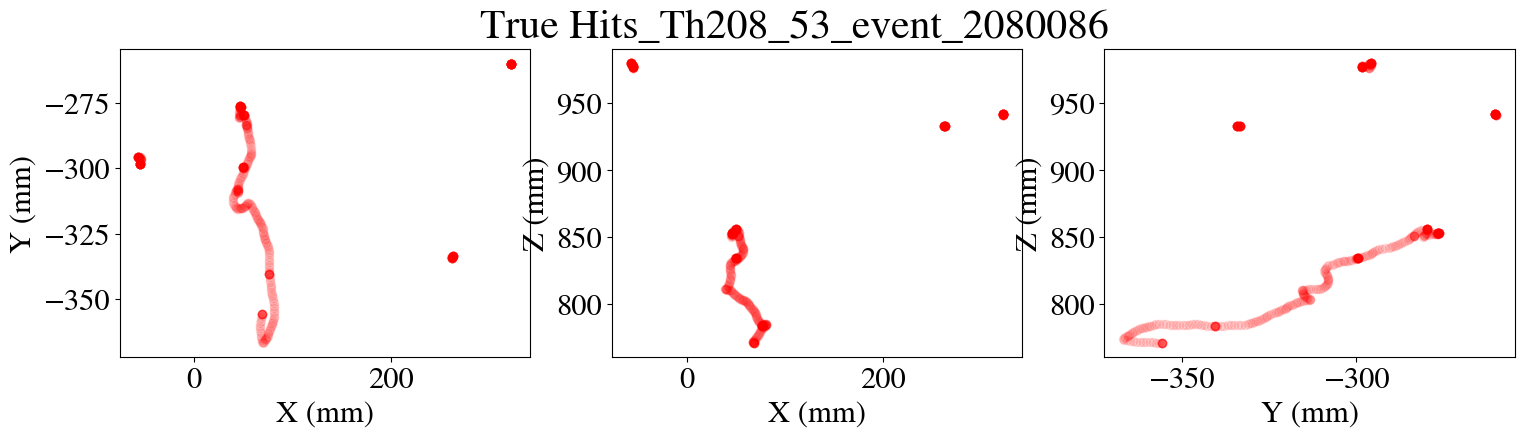

In [29]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + dir_name, fontsize=30)
    fig.savefig(pre_dir_name + dir_name + "/MC_hits")

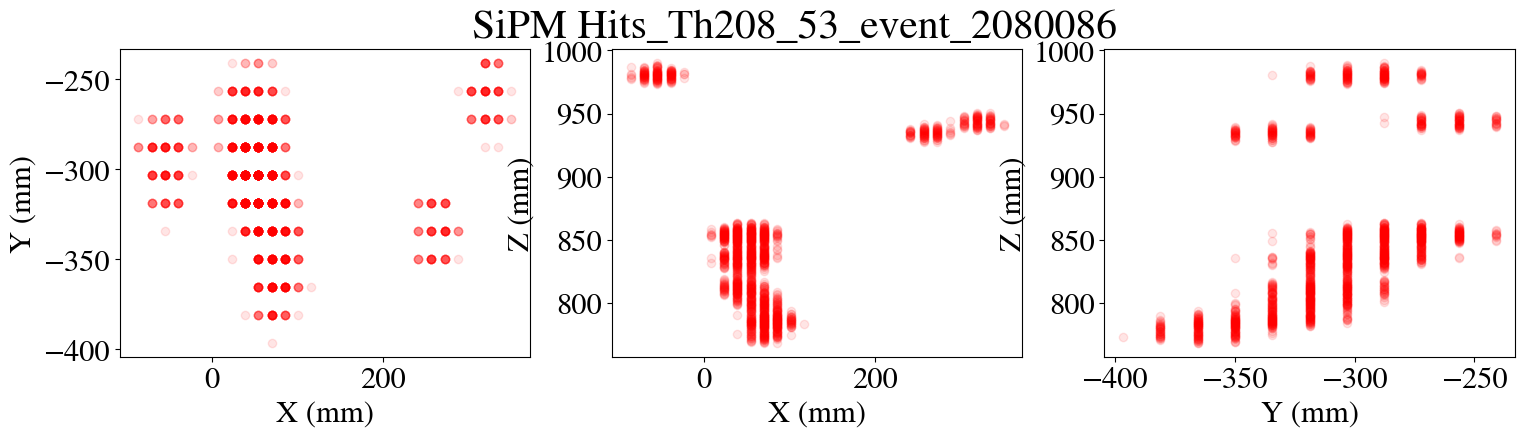

In [30]:
# plotting sipm data normally
# true data type plots

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")

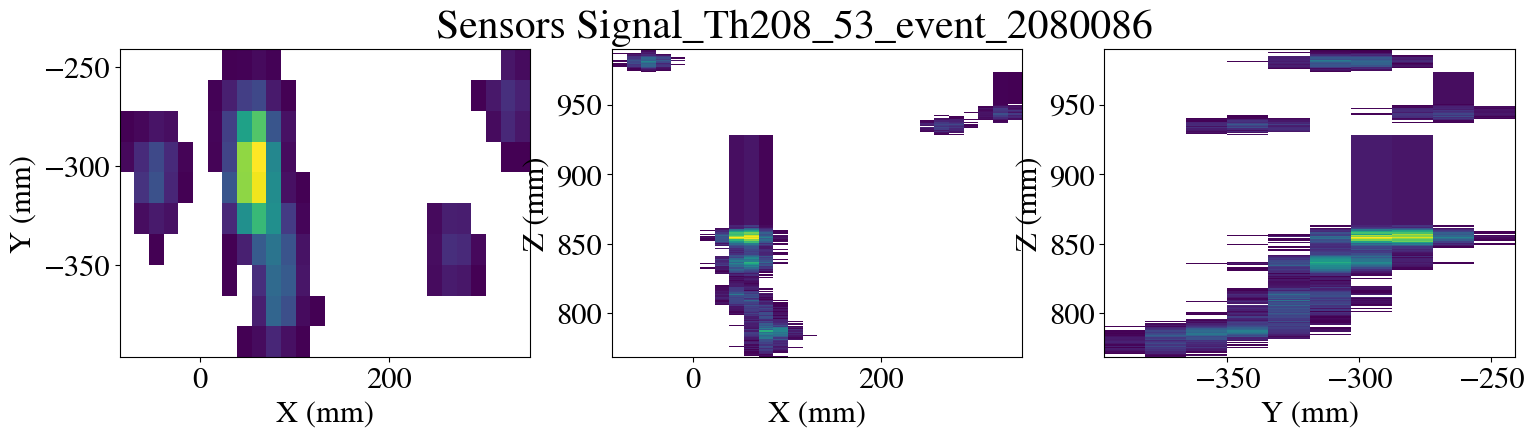

In [31]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")

#### Cut sensors

 Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [32]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 5


In [33]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.028502702713012695 s


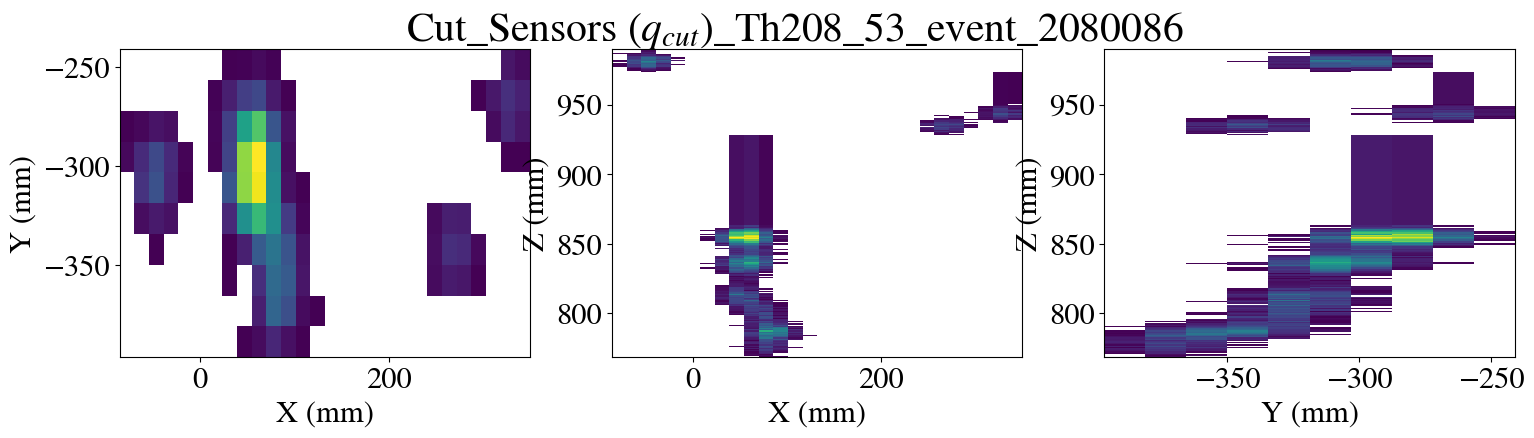

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")

Increased cut to see the impact of the function on higher thresholds:

In [35]:
cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.0173647403717041 s


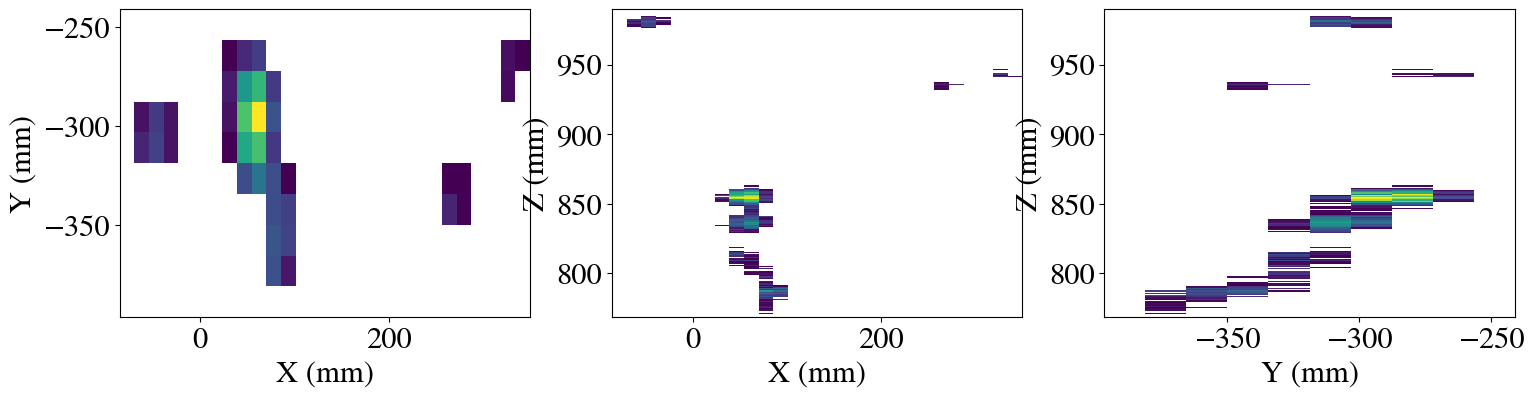

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the remaining hits so the total energy of the event remains the same:

In [37]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    889723.008190147 (2.6203585815521513)
Energy (corrected) after low cut:  889723.008190147 (2.6203585815521513)
Energy (corrected) after high cut: 889723.008190147 (2.620358581552151)


#### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [38]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.04725027084350586 s


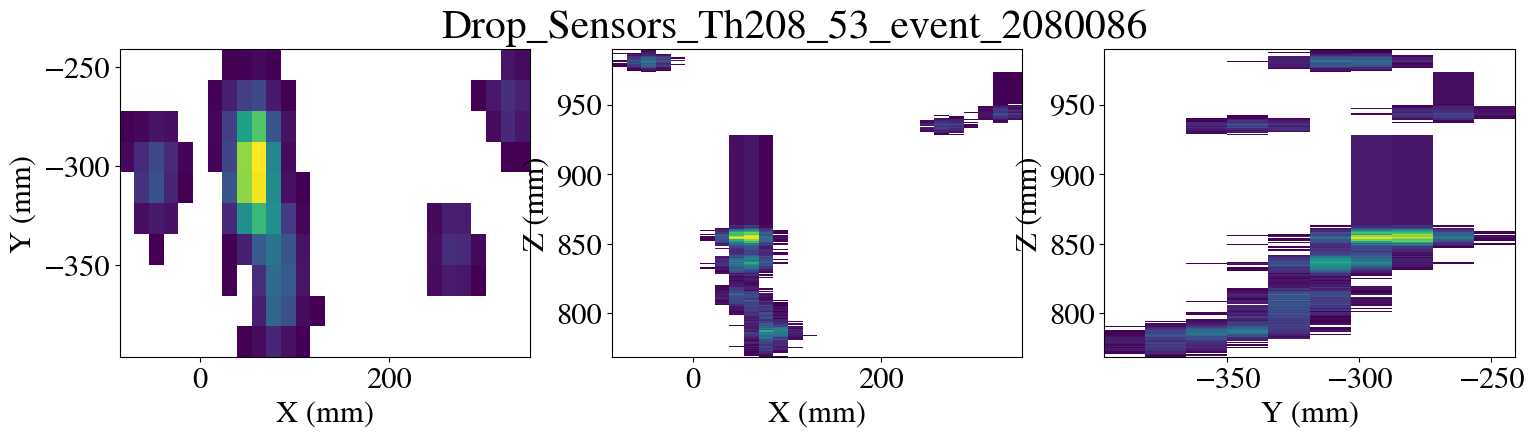

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")


It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [40]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [41]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
1558,2080086.0,2.080087e+12,2.0,-55.138987,-295.775660,1.0,-54.425,-303.225,0.0,0.0,987.388489,9.797101,692.095181,-1.0,0.002049,-1.0,-1.0
1559,2080086.0,2.080087e+12,2.0,-55.138987,-295.775660,1.0,-54.425,-287.675,0.0,0.0,987.388489,6.260870,442.285693,-1.0,0.001301,-1.0,-1.0
1560,2080086.0,2.080087e+12,2.0,-55.138987,-295.775660,1.0,-54.425,-303.225,0.0,0.0,988.221863,6.956522,1042.000000,-1.0,0.003085,-1.0,-1.0
1561,2080086.0,2.080087e+12,2.0,-55.138987,-295.775660,1.0,-54.425,-287.675,0.0,0.0,989.901062,5.043478,1584.000000,-1.0,0.004661,-1.0,-1.0
1562,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,-250.000,-250.000,0.0,0.0,768.197083,1000.000000,908.000024,-1.0,0.002728,-1.0,-1.0


### be not afraid of these plots, notebook-wanderer. For these are purposefully crap to demonstrate how to modify the event

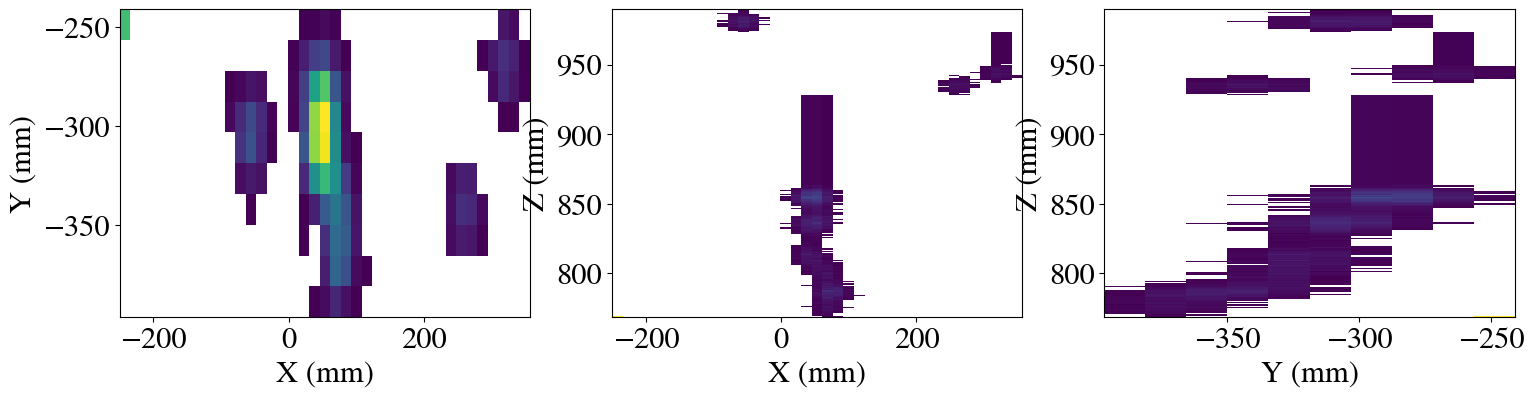

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + pitch, pitch)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



And now after cut:


In [43]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.032470703125 s


In [44]:
hits_drop.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-365.425,0.0,0.0,768.197083,5.101449,909.166797,-1.0,0.002732,-1.0,-1.0
1,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,85.525,-365.425,0.0,0.0,768.197083,6.376812,1136.458432,-1.0,0.003430,-1.0,-1.0
2,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,54.425,-349.875,0.0,0.0,769.036743,5.101449,301.908950,-1.0,0.000890,-1.0,-1.0
3,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-365.425,0.0,0.0,769.036743,6.840580,404.832426,-1.0,0.001217,-1.0,-1.0
4,2080086.0,2.080087e+12,0.0,55.666378,-307.770279,1.0,69.975,-349.875,0.0,0.0,769.036743,6.956522,411.693991,-1.0,0.001215,-1.0,-1.0


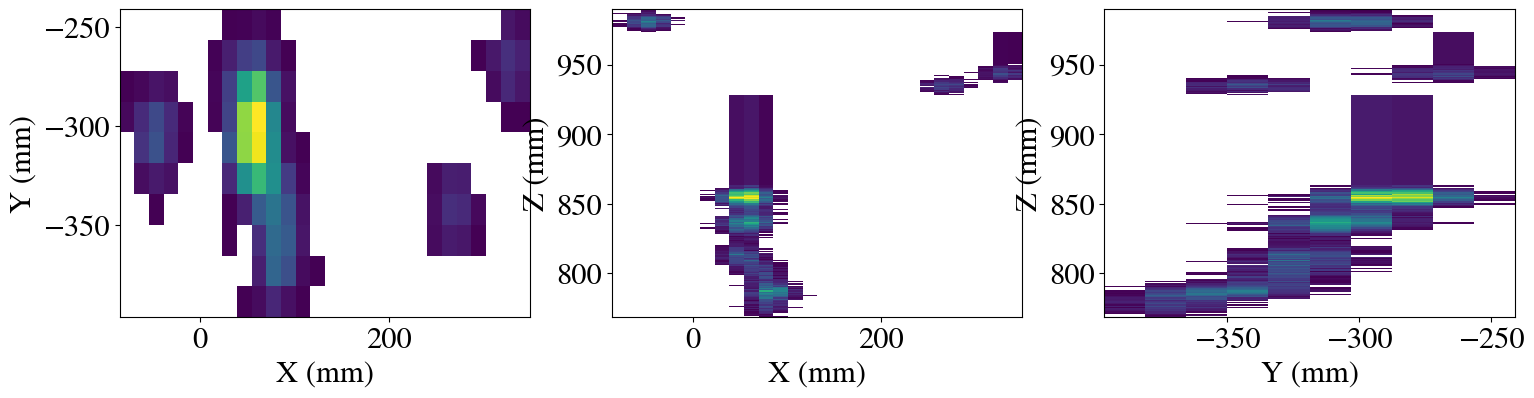

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to hits_copy which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [46]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 890631.0082139109 (2.623086814142698)
Energy (corrected) after  cut: 890631.0082139107 (2.623086814142698)


Recover the hits as they should (normal cuts):

In [47]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.0207672119140625 s
Time spent in drop_isolated: 0.02904653549194336 s


#### Deconvolve Signal 

Last function in the city is deconvolve_signal which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, deconvolve_signal assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak.

Hereunder, deconvolve_signal output will be showed. Individual performance of each step will be looked into later in the notebook.

In [57]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 15.46107268333435 s


In [ ]:
# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']
print(save_state)

100


In [58]:


for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

15 iterations
Time spent in apply_deconvolution: 3.368788480758667 s
30 iterations
Time spent in apply_deconvolution: 5.406727313995361 s
45 iterations
Time spent in apply_deconvolution: 7.499359369277954 s
60 iterations
Time spent in apply_deconvolution: 9.345871925354004 s
75 iterations
Time spent in apply_deconvolution: 11.717660188674927 s
90 iterations
Time spent in apply_deconvolution: 13.481823682785034 s


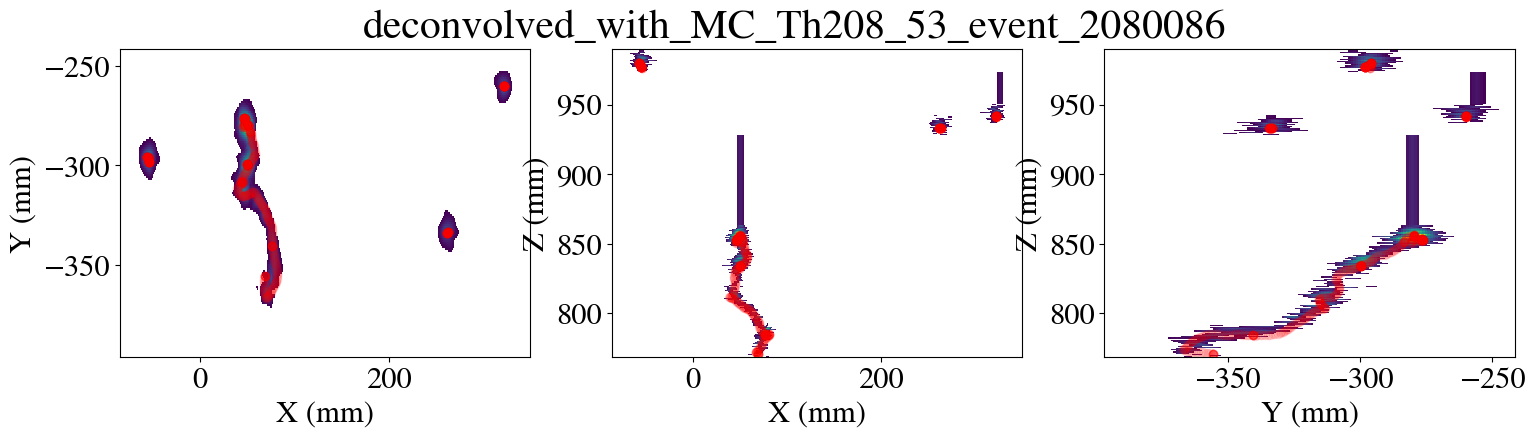

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")

In [60]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E*1000

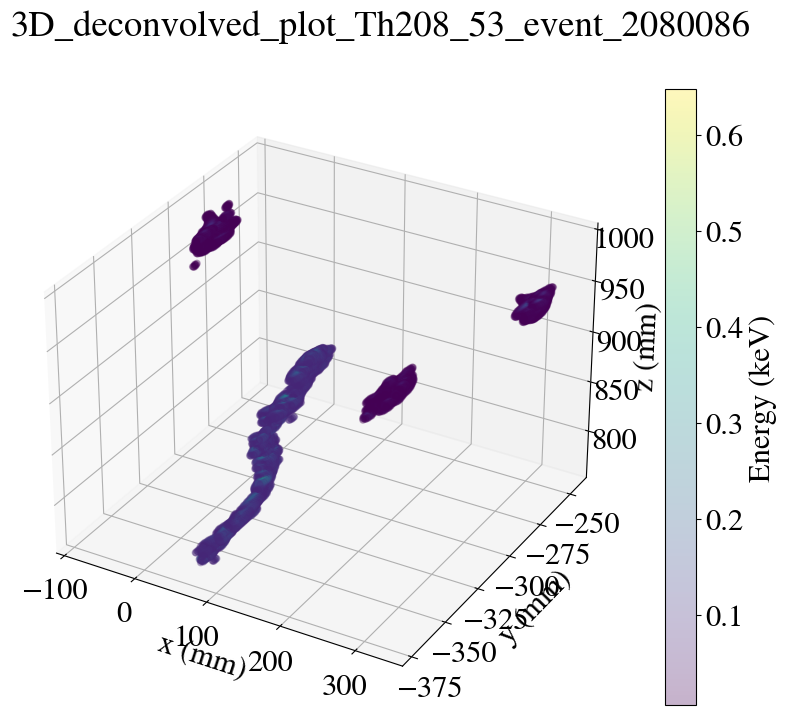

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

/tmp/ipykernel_32698/975472362.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


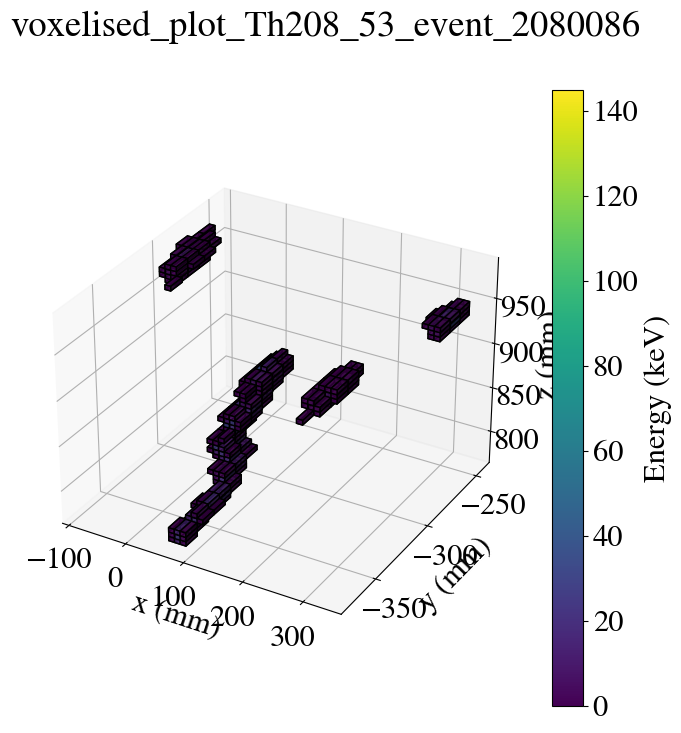

In [62]:
base_vsize = 5 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize*2, base_vsize*2, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

plt.show()

In [52]:
hits_deco.head()

,event,npeak,X,Y,Z,E
0,2080000,0.0,70.675,10.675,229.781265,0.000033
1,2080000,0.0,70.675,11.675,229.781265,0.000048
2,2080000,0.0,70.675,12.675,229.781265,0.000056
3,2080000,0.0,70.675,13.675,229.781265,0.000051
4,2080000,0.0,70.675,14.675,229.781265,0.000038


In [53]:
break;

SyntaxError: 'break' outside loop (1693679151.py, line 1)

### Create a loop that does it all

In [61]:
display(hdst.event.unique()[35:])



array([2080070, 2080072, 2080074, ..., 2083606, 2083608, 2083610],
      dtype=int32)

In [75]:
for i in range(len(hdst.event.unique())):
	evt = hdst.event.unique()[35+i]						# NOTE This line has been changed to collect further along events
	hits = hdst[hdst.event == evt]
	
	x_range = (hits.X.max()-hits.X.min())/2.
	y_range = (hits.Y.max()-hits.Y.min())/2.
	z_range = (hits.Z.max()-hits.Z.min())/2.
	mid_x   = (hits.X.max()+hits.X.min())/2.
	mid_y   = (hits.Y.max()+hits.Y.min())/2.
	mid_z   = (hits.Z.max()+hits.Z.min())/2.

	print("X maximum and minimum")
	print(hits.X.max(), hits.X.min())
	print("")

	print("Y maximum and minimum")
	print(hits.Y.max(), hits.Y.min())
	print("")

	print("Z maximum and minimum")
	print(hits.Z.max(), hits.Z.min())

	xbins = int(hits.X.max()-hits.X.min())
	ybins = int(hits.Y.max()-hits.Y.min())
	zbins = int((hits.Z.max()-hits.Z.min())/2.)
	
	
	if (datatype == 'MC'):
	    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
	    true_info = mcio.load_mchits_df(soph_file).reset_index()
	    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
	    
	    
	    this_evt_true_info = true_info[true_info.event_id == evt]

	    xt = this_evt_true_info.x
	    yt = this_evt_true_info.y
	    zt = this_evt_true_info.z
	    et = this_evt_true_info.energy*1000
	
	no = this_evt_true_info['event_id'].to_numpy()[0]
	file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
	dir_name = "Th208_" + file_number + "_event_" + str(no)

	pre_dir_name = 'HPR_beersheba_event_plots/'

	if not os.path.isdir(pre_dir_name + dir_name):
	    os.mkdir(pre_dir_name +dir_name)
	
	
	# true data type plots
	if (datatype == 'MC'):
	    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	    axes[0].set_xlabel('X (mm)');
	    axes[0].set_ylabel('Y (mm)');

	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	    axes[1].set_xlabel('X (mm)');
	    axes[1].set_ylabel('Z (mm)');

	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	    axes[2].set_xlabel('Y (mm)');
	    axes[2].set_ylabel('Z (mm)');
	    
	    fig.suptitle('True Hits_' + dir_name, fontsize=30)
	    fig.savefig(pre_dir_name + dir_name + "/MC_hits")
	    plt.close()
	   
	# plotting sipm data normally
	# true data type plots

	fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
	plt.close()
	
	
	
	# then applying transformations to convert to 'SiPM outputs'
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))


	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
	plt.close()
	
	
	qmin = deconv_params['q_cut']
	print(f'Cutting sensors below {qmin}')
	
	hits_cut = coref.timefunc(cut_sensors)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
	plt.close()
	
	
	cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
	hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()
	
	
	print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
	print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
	
	
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
	plt.close()
	
	print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
	
	hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	
	
	# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
	if 'save_state' in locals():
	    deconv_params_['n_iterations'] = save_state
	else:
	    # first time round, so set it
	    save_state = deconv_params_['n_iterations']
	print(save_state)
	
	
	
		
	for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
	    deconv_params_['n_iterations'] = iterN
	    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	    print(f'{iterN} iterations')
	    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	    
	    
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max())
	yy = np.arange(hits.Y.min(), hits.Y.max())
	zz = hits.Z.unique()

	axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()


	fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
	
	x = hits_deco.X
	y = hits_deco.Y
	z = hits_deco.Z
	e = hits_deco.E*1000
	
	
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
	cb = fig.colorbar(p, ax=ax)
	cb.set_label('Energy (keV)')

	ax.set_xlabel('x (mm)')
	ax.set_ylabel('y (mm)')
	ax.set_zlabel('z (mm)')

	fig.suptitle('3D_deconvolved_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

	plt.close()
	
	
	base_vsize = 5 #mm
	the_hits = []

	xs = hits_deco.X
	ys = hits_deco.Y
	zs = hits_deco.Z
	es = hits_deco.E

	for x, y, z, e in zip(xs, ys, zs, es):
	    if np.isnan(e): continue
	    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
	    the_hits.append(h)

	voxels = voxelize_hits(the_hits,
		               np.array([base_vsize*2, base_vsize*2, base_vsize]), False)

	vsizex = voxels[0].size[0]
	vsizey = voxels[0].size[1]
	vsizez = voxels[0].size[2]

	min_corner_x = min(v.X for v in voxels) - vsizex/2.
	min_corner_y = min(v.Y for v in voxels) - vsizey/2.
	min_corner_z = min(v.Z for v in voxels) - vsizez/2.

	x = [np.round(v.X/vsizex) for v in voxels]
	y = [np.round(v.Y/vsizey) for v in voxels]
	z = [np.round(v.Z/vsizez) for v in voxels]
	e = [v.E for v in voxels]

	x_min = int(min(x))
	y_min = int(min(y))
	z_min = int(min(z))

	x_max = int(max(x))
	y_max = int(max(y))
	z_max = int(max(z))

	#print(f'X min = {x_min}, X max = {x_max}')
	#print(f'Y min = {y_min}, Y max = {y_max}')
	#print(f'Z min = {z_min}, Z max = {z_max}')

	VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
	#print(VOXELS.shape)

	# sort through the event set the "turn on" the hit voxels
	cmap = cm.viridis
	norm = Normalize(vmin=0, vmax=max(e))

	colors = np.empty(VOXELS.shape, dtype=object)
	for q in range(0,len(z)):
	    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
	    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

	# and plot everything
	fig = plt.figure(figsize=(8,8))
	ax = fig.gca(projection='3d')
	#a,b,c is spacing in mm needs an extra dim
	a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
	a = a*vsizex + min_corner_x
	b = b*vsizey + min_corner_y
	c = c*vsizez + min_corner_z

	# a, b, c are the corners of the voxels
	ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

	ax.set_xlabel('x (mm)')#,fontsize=16)
	ax.set_ylabel('y (mm)')#,fontsize=16)
	ax.set_zlabel('z (mm)')#,fontsize=16)

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cb = fig.colorbar(sm)
	cb.set_label('Energy (keV)')

	fig.suptitle('voxelised_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

	plt.close()

X maximum and minimum
334.325 -69.975

Y maximum and minimum
396.525 7.775

Z maximum and minimum
636.2553100585938 560.683837890625
Cutting sensors below 5
Time spent in cut_over_Q: 0.025957822799682617 s
Time spent in cut_over_Q: 0.014209270477294922 s
Energy (corrected) before cuts:    181823.9986603445 (0.4861484286298533)
Energy (corrected) after low cut:  181823.9986603445 (0.4861484286298533)
Energy (corrected) after high cut: 172398.99859966597 (0.4546354095200682)
Time spent in drop_isolated: 0.00918889045715332 s
Energy (corrected) before cut: 181823.9986603445 (0.4861484286298533)
Energy (corrected) after  cut: 181823.9986603445 (0.4861484286298533)
Time spent in cut_over_Q: 0.02380537986755371 s
Time spent in drop_isolated: 0.009595632553100586 s
Time spent in apply_deconvolution: 3.4569849967956543 s
100
15 iterations
Time spent in apply_deconvolution: 0.8520030975341797 s
30 iterations
Time spent in apply_deconvolution: 1.3135919570922852 s
45 iterations
Time spent in app

/tmp/ipykernel_18422/2728978073.py:341: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


X maximum and minimum
458.725 256.575

Y maximum and minimum
334.325 -23.325

Z maximum and minimum
442.22271728515625 291.9417419433594
Cutting sensors below 5
Time spent in cut_over_Q: 0.01957559585571289 s
Time spent in cut_over_Q: 0.013589143753051758 s
Energy (corrected) before cuts:    78110.0011964305 (0.06312610819842834)
Energy (corrected) after low cut:  78110.0011964305 (0.06312610819842834)
Energy (corrected) after high cut: 78110.00119643049 (0.051607403746419894)
Time spent in drop_isolated: 0.007180690765380859 s
Energy (corrected) before cut: 78110.0011964305 (0.06312610819842834)
Energy (corrected) after  cut: 78110.0011964305 (0.06312610819842834)
Time spent in cut_over_Q: 0.014317750930786133 s
Time spent in drop_isolated: 0.007500171661376953 s
Time spent in apply_deconvolution: 1.8194773197174072 s
100
15 iterations
Time spent in apply_deconvolution: 0.4557342529296875 s
30 iterations
Time spent in apply_deconvolution: 0.8037054538726807 s
45 iterations
Time spent 

KeyboardInterrupt: 